# Preliminaries

In [47]:
from copy import deepcopy
from random import random
from abc import abstractmethod

import numpy as np
from scipy.linalg import solve
import matplotlib.pyplot as plt

In [48]:



class Event:
    """
    Abstract class used by Event Models. 

    To instantiate an event, you must override:
     - rate function | (state, time, parameters) -> nonnegative number
     - max rate function | (state, parameters) -> nonnegative number
     - implement function | state -> state
    """

    @abstractmethod
    def get_rate(self, state, time, model_parameters):
        """Returns the instantaneous rate at which the event occurs at the current state and time."""

    @abstractmethod
    def implement(self, state,**kwargs):
        """Returns the new state after event is implemented.
        Mutates the state to become the new state."""    

class Model:
    name = "Event-Driven Model"

    def __init__(self, events: list[Event]):
        self.events = events

    def run(self, parameters: dict, initial_state, duration: float, max_num_steps=None, verbose=False):
        """
        Returns the result of running the model. Does not mutate any of the arguments.  
        """
        current_state = deepcopy(initial_state)
        current_time = 0
        num_steps = 0
        while True:
            num_steps += 1
            if max_num_steps is not None and num_steps > max_num_steps:
                raise RuntimeError(
                    "Maximum number of steps for single simulation exceeded")
            rates = []
            for event in self.events:
                rates.append(event.get_rate(current_state, parameters))
            total_rate = sum(rates)
            if total_rate == 0:
                break
            else:
                random_number = random()
                waiting_time = - np.log(random_number) / total_rate
            current_time += waiting_time
            
            if current_time > duration:
                break
            event_index = random() * total_rate
            found_event = None
            for event, rate in zip(self.events, rates):
                if rate >= event_index:
                    found_event = event
                    current_state = found_event.implement(current_state)
                    break
                event_index -= rate
        return current_state

    def run_timepoints(self, parameters, initial_state, timepoints):
        last_timepoint = 0
        state = deepcopy(initial_state)
        result = []
        for timepoint in timepoints:
            new_state = self.run(parameters, state, timepoint - last_timepoint)
            result.append(new_state)
            state = new_state
            last_timepoint = timepoint
        return result


    

In [49]:
    
class TCellDeath(Event):
    def __init__(self, bound_CSAN_count):
        self.bound_CSAN_count = bound_CSAN_count

    def get_rate(self, state, parameters):
        return state.Es[self.bound_CSAN_count] * parameters["d_E"]

    def implement(self, state):
        state.Es[self.bound_CSAN_count] = state.Es[self.bound_CSAN_count] - 1
        state.D = state.D + self.bound_CSAN_count
        return state

class TumorBirth(Event):
    def __init__(self, bound_CSAN_count):
        self.bound_CSAN_count = bound_CSAN_count
    
    def get_rate(self, state, parameters):
        return state.Ts[self.bound_CSAN_count] * parameters["b_T"]
        

    def implement(self, state):
        state.Ts[self.bound_CSAN_count] = state.Ts[self.bound_CSAN_count] - 1
        child_csans = np.random.binomial(self.bound_CSAN_count, 0.5)
        child_csans2 = self.bound_CSAN_count - child_csans
        state.Ts[child_csans] = state.Ts[child_csans] + 1
        state.Ts[child_csans2] = state.Ts[child_csans2] + 1
        return state
 
class TCellBinding(Event):
    def __init__(self, bound_CSAN_count, receptor_count):
        self.bound_CSAN_count = bound_CSAN_count
        self.receptor_count = receptor_count
        self.free_receptor_count = self.receptor_count - self.bound_CSAN_count
    
    def get_rate(self, state, parameters):
        return state.D * self.free_receptor_count * state.Es[self.bound_CSAN_count] * parameters["lambda_E"]
        
    
    def implement(self, state):
        state.D = state.D - 1
        state.Es[self.bound_CSAN_count] = state.Es[self.bound_CSAN_count] - 1
        state.Es[self.bound_CSAN_count + 1] = state.Es[self.bound_CSAN_count + 1] + 1
        return state

class TumorBinding(Event):
    def __init__(self, bound_CSAN_count, receptor_count):
        self.bound_CSAN_count = bound_CSAN_count
        self.receptor_count = receptor_count
        self.free_receptor_count = self.receptor_count - self.bound_CSAN_count
    
    def get_rate(self, state, parameters):
        return state.D * self.free_receptor_count * state.Ts[self.bound_CSAN_count] * parameters["lambda_T"]
         
    def implement(self, state):
        state.D = state.D - 1
        state.Ts[self.bound_CSAN_count] = state.Ts[self.bound_CSAN_count] - 1
        state.Ts[self.bound_CSAN_count + 1] = state.Ts[self.bound_CSAN_count + 1] + 1
        return state

class TCellInternalization(Event):
    def __init__(self, bound_CSAN_count, receptor_count):
        self.bound_CSAN_count = bound_CSAN_count
        self.receptor_count = receptor_count
        self.free_receptor_count = self.receptor_count - self.bound_CSAN_count
    
    def get_rate(self, state, parameters):
        return self.bound_CSAN_count * state.Es[self.bound_CSAN_count] * parameters["mu_E"]
        
    
    def implement(self, state):
        state.Es[self.bound_CSAN_count] = state.Es[self.bound_CSAN_count] - 1
        state.Es[self.bound_CSAN_count - 1] = state.Es[self.bound_CSAN_count - 1] + 1
        return state

class TumorInternalization(Event):
    def __init__(self, bound_CSAN_count, receptor_count):
        self.bound_CSAN_count = bound_CSAN_count
        self.receptor_count = receptor_count
        self.free_receptor_count = self.receptor_count - self.bound_CSAN_count
    
    def get_rate(self, state, parameters):
        return self.bound_CSAN_count * state.Ts[self.bound_CSAN_count] * parameters["mu_T"]
        
    
    def implement(self, state):
        state.Ts[self.bound_CSAN_count] = state.Ts[self.bound_CSAN_count] - 1
        state.Ts[self.bound_CSAN_count - 1] = state.Ts[self.bound_CSAN_count - 1] + 1
        return state

class ED_TFormation(Event):
    def __init__(self, TCell_bound_count, tumor_bound_count, TCell_receptors, tumor_receptors):
        self.TCell_bound_count = TCell_bound_count
        self.tumor_bound_count = tumor_bound_count
        self.TCell_receptors = TCell_receptors
        self.tumor_receptors = tumor_receptors

    def get_rate(self, state, model_parameters):
        p_e_t = model_parameters["p_E|T"]
        p_ed_t = model_parameters["p_ED|T"]
        p_e_dt = model_parameters["p_E|DT"]
        lambda_ET = model_parameters["lambda_ET"]
        m = model_parameters["M"]
        c_e_t = (self.TCell_receptors - self.TCell_bound_count) * (self.tumor_receptors - self.tumor_bound_count) * p_e_t / (self.TCell_receptors * self.tumor_receptors)
        c_e_dt = (self.TCell_receptors - self.TCell_bound_count) * self.tumor_bound_count * p_e_dt / (self.TCell_receptors * self.tumor_receptors)
        c_ed_t = self.TCell_bound_count * (self.tumor_receptors - self.tumor_bound_count) * p_ed_t / (self.TCell_receptors * self.tumor_receptors)

        c_f = 1 - c_e_t - c_e_dt - c_ed_t
        if c_f == 1:
            return 0

        return lambda_ET * (1 - c_f ** m) * state.Es[self.TCell_bound_count] * state.Ts[self.tumor_bound_count] * c_ed_t / (c_e_t + c_e_dt + c_ed_t)

    def implement(self, state):
        state.Es[self.TCell_bound_count] = state.Es[self.TCell_bound_count] - 1
        state.Ts[self.tumor_bound_count] = state.Ts[self.tumor_bound_count] - 1
        state.EDTs[self.TCell_bound_count - 1][self.tumor_bound_count] = state.EDTs[self.TCell_bound_count - 1][self.tumor_bound_count] + 1
        return state
    
class E_DTFormation(Event):
    def __init__(self, TCell_bound_count, tumor_bound_count, TCell_receptors, tumor_receptors):
        self.TCell_bound_count = TCell_bound_count
        self.tumor_bound_count = tumor_bound_count
        self.TCell_receptors = TCell_receptors
        self.tumor_receptors = tumor_receptors

    def get_rate(self, state, model_parameters):
        p_e_t = model_parameters["p_E|T"]
        p_ed_t = model_parameters["p_ED|T"]
        p_e_dt = model_parameters["p_E|DT"]
        lambda_ET = model_parameters["lambda_ET"]
        m = model_parameters["M"]
        c_e_t = (self.TCell_receptors - self.TCell_bound_count) * (self.tumor_receptors - self.tumor_bound_count) * p_e_t / (self.TCell_receptors * self.tumor_receptors)
        c_e_dt = (self.TCell_receptors - self.TCell_bound_count) * self.tumor_bound_count * p_e_dt / (self.TCell_receptors * self.tumor_receptors)
        c_ed_t = self.TCell_bound_count * (self.tumor_receptors - self.tumor_bound_count) * p_ed_t / (self.TCell_receptors * self.tumor_receptors)

        c_f = 1 - c_e_t - c_e_dt - c_ed_t

        
        if c_f == 1:
            return 0
        return lambda_ET * (1 - c_f ** m) * state.Es[self.TCell_bound_count] * state.Ts[self.tumor_bound_count] * c_e_dt / (c_e_t + c_e_dt + c_ed_t)

    def implement(self, state):
        state.Es[self.TCell_bound_count] = state.Es[self.TCell_bound_count] - 1
        state.Ts[self.tumor_bound_count] = state.Ts[self.tumor_bound_count] - 1
        state.EDTs[self.TCell_bound_count][self.tumor_bound_count - 1] = state.EDTs[self.TCell_bound_count][self.tumor_bound_count - 1] + 1
        return state
    
class E_TFormation(Event):
    def __init__(self, TCell_bound_count, tumor_bound_count, TCell_receptors, tumor_receptors):
        self.TCell_bound_count = TCell_bound_count
        self.tumor_bound_count = tumor_bound_count
        self.TCell_receptors = TCell_receptors
        self.tumor_receptors = tumor_receptors

    def get_rate(self, state, model_parameters):
        p_e_t = model_parameters["p_E|T"]
        p_ed_t = model_parameters["p_ED|T"]
        p_e_dt = model_parameters["p_E|DT"]
        lambda_ET = model_parameters["lambda_ET"]
        m = model_parameters["M"]
        c_e_t = (self.TCell_receptors - self.TCell_bound_count) * (self.tumor_receptors - self.tumor_bound_count) * p_e_t / (self.TCell_receptors * self.tumor_receptors)
        c_e_dt = (self.TCell_receptors - self.TCell_bound_count) * self.tumor_bound_count * p_e_dt / (self.TCell_receptors * self.tumor_receptors)
        c_ed_t = self.TCell_bound_count * (self.tumor_receptors - self.tumor_bound_count) * p_ed_t / (self.TCell_receptors * self.tumor_receptors)

        c_f = 1 - c_e_t - c_e_dt - c_ed_t

        
        if c_f == 1:
            return 0
        return lambda_ET * (1 - c_f ** m) * state.Es[self.TCell_bound_count] * state.Ts[self.tumor_bound_count] * c_e_t / (c_e_t + c_e_dt + c_ed_t)

    def implement(self, state):
        state.Es[self.TCell_bound_count] = state.Es[self.TCell_bound_count] - 1
        state.Ts[self.tumor_bound_count] = state.Ts[self.tumor_bound_count] - 1
        state.ETs[self.TCell_bound_count][self.tumor_bound_count] = state.ETs[self.TCell_bound_count][self.tumor_bound_count] + 1
        return state
    
class TrimerDeath(Event):
    def __init__(self, TCell_bound_count, tumor_bound_count, TCell_receptors, tumor_receptors):
        self.TCell_bound_count = TCell_bound_count
        self.tumor_bound_count = tumor_bound_count
        self.TCell_receptors = TCell_receptors
        self.tumor_receptors = tumor_receptors

    def get_rate(self, state, model_parameters):
        d_EDT = model_parameters["d_EDT"]
        return d_EDT * state.EDTs[self.TCell_bound_count][self.tumor_bound_count]
    
    def implement(self, state):
        state.EDTs[self.TCell_bound_count][self.tumor_bound_count] = state.EDTs[self.TCell_bound_count][self.tumor_bound_count] - 1
        state.D = state.D + self.tumor_bound_count
        state.Es[self.TCell_bound_count + 1] = state.Es[self.TCell_bound_count + 1] + 1 
        return state
    
class DimerDeath(Event):
    def __init__(self, TCell_bound_count, tumor_bound_count, TCell_receptors, tumor_receptors):
        self.TCell_bound_count = TCell_bound_count
        self.tumor_bound_count = tumor_bound_count
        self.TCell_receptors = TCell_receptors
        self.tumor_receptors = tumor_receptors
    
    def get_rate(self, state, model_parameters):
        d_ET = model_parameters["d_ET"]
        return d_ET * state.ETs[self.TCell_bound_count][self.tumor_bound_count]
    
    def implement(self, state):
        state.ETs[self.TCell_bound_count][self.tumor_bound_count] = state.ETs[self.TCell_bound_count][self.tumor_bound_count] - 1
        state.D = state.D + self.tumor_bound_count
        state.Es[self.TCell_bound_count] = state.Es[self.TCell_bound_count] + 1 
        return state


class State:
    def __init__(self, D, Es, Ts, EDTs, ETs):
        self.D = D
        self.Es = Es
        self.Ts = Ts
        self.EDTs = EDTs
        self.ETs = ETs

    def verify_coherence(self):
        if self.D < 0 or not isinstance(self.D, int):
            return False
        for E in self.Es:
            if E < 0:
                return False
        for T in self.Ts:
            if T < 0:
                return False
        for EDT_by_E in self.EDTs:
            for EDT in EDT_by_E:
                if EDT < 0:
                    return False
        for ET_by_E in self.ETs:
            for ET in ET_by_E:
                if ET < 0:
                    return False
        return True

    def E(self):
        return sum(self.Es)
    
    def T(self):
        return sum(self.Ts)
    
    def EDT(self):
        return sum([sum(row) for row in self.EDTs])
    
    def ET(self):
        return sum([sum(row) for row in self.ETs])

    def total_D(self):
        total = self.D
        for i, E in enumerate(self.Es):
            total += i * E
        for i, T in enumerate(self.Ts):
            total += i * T
        for i, row in enumerate(self.EDTs):
            for j, EDT in enumerate(row):
                total += (i + j + 1) * EDT
        for i, row in enumerate(self.ETs):
            for j, ET in enumerate(row):
                total += (i + j) * ET
        return total

    def bound_D_per_E(self):
        total_bound_D = 0
        total_E = 0
        for i, E in enumerate(self.Es):
            total_bound_D += i * E
            total_E += E
        if total_bound_D == 0:
            return total_bound_D
        return total_bound_D / total_E
    
    def bound_D_per_T(self):
        total_bound_D = 0
        total_T = 0
        for i, T in enumerate(self.Ts):
            total_bound_D += i * T
            total_T += T
        if total_bound_D == 0:
            return total_bound_D
        return total_bound_D / total_T

    def export_to_list(self):
        l = [self.D]
        for e in self.Es:
            l.append(e)
        for t in self.Ts:
            l.append(t)
        for l1 in self.EDTs:
            for edt in l1:
                l.append(edt)
        for l1 in self.ETs:
            for et in l1:
                l.append(et)
        return l

    @staticmethod
    def import_from_list(l, e_receptors, t_receptors):
        Ds_end = 1
        D = l[0]
        Es_end = Ds_end + e_receptors + 1
        Es = l[Ds_end: Es_end]
        Ts_end = Es_end + t_receptors + 1
        Ts = l[Es_end:Ts_end]
        EDTs = []
        for i in range(e_receptors):
            start = Ts_end + i * t_receptors
            end = Ts_end + (i + 1) * t_receptors
            EDTs.append(l[start:end])
        ETs = []
        for i in range(e_receptors):
            start = Ts_end + i * t_receptors + t_receptors * e_receptors
            end = Ts_end + (i + 1) * t_receptors + t_receptors * e_receptors
            ETs.append(l[start:end])
        return State(D, Es, Ts, EDTs, ETs)
        

    def __repr__(self):
        return f"D: {self.D}. Es: {self.Es}. Ts: {self.Ts}. EDTs: {self.EDTs}. ETs: {self.ETs}"

    def __add__(self, other):
        return State(
            self.D + other.D, 
            [e1 + e2 for e1, e2 in zip(self.Es, other.Es)], 
            [t1 + t2 for t1, t2 in zip(self.Ts, other.Ts)],
            [[edt1 + edts for edt1, edt2 in zip(l1, l2)] for l1, l2 in zip(self.EDTs, other.EDTs)],
            [[et1 + ets for et1, et2 in zip(l1, l2)] for l1, l2 in zip(self.ETs, other.ETs)]
            )
    
    def __sub__(self, other):
        return State(
            self.D - other.D, 
            [e1 - e2 for e1, e2 in zip(self.Es, other.Es)], 
            [t1 - t2 for t1, t2 in zip(self.Ts, other.Ts)],
            [[edt1 - edts for edt1, edt2 in zip(l1, l2)] for l1, l2 in zip(self.EDTs, other.EDTs)],
            [[et1 - ets for et1, et2 in zip(l1, l2)] for l1, l2 in zip(self.ETs, other.ETs)],
            )

    def __mul__(self, other):
        return State(
            self.D * other, 
            [e1 * other for e1 in self.Es], 
            [t1 * other for t1 in self.Ts],
            [[edt1 * other for edt1 in l1] for l1 in self.EDTs],
            [[et1 * other for et1 in l1] for l1 in self.ETs]
            )

class CSANModel(Model):
    def __init__(self, e_receptors, t_receptors):
        self.e_receptors = e_receptors
        self.t_receptors = t_receptors

        events = []
        for bound_CSAN_count in range(e_receptors + 1):
            events.append(TCellDeath(bound_CSAN_count))
            events.append(TCellBinding(bound_CSAN_count, e_receptors))
            events.append(TCellInternalization(bound_CSAN_count, e_receptors))
        for bound_CSAN_count in range(t_receptors + 1):
            events.append(TumorBirth(bound_CSAN_count))
            events.append(TumorBinding(bound_CSAN_count, t_receptors))
            events.append(TumorInternalization(bound_CSAN_count, t_receptors))

        for TCell_bound_count in range(e_receptors + 1):
            for tumor_bound_count in range(t_receptors + 1):
                events.append(ED_TFormation(TCell_bound_count, tumor_bound_count, e_receptors, t_receptors))
                events.append(E_DTFormation(TCell_bound_count, tumor_bound_count, e_receptors, t_receptors))
                events.append(E_TFormation(TCell_bound_count, tumor_bound_count, e_receptors, t_receptors))
                
        for TCell_bound_count in range(e_receptors):
            for tumor_bound_count in range(t_receptors):
                events.append(TrimerDeath(TCell_bound_count, tumor_bound_count, e_receptors, t_receptors)) 
                events.append(DimerDeath(TCell_bound_count, tumor_bound_count, e_receptors, t_receptors))
        self.events = events
    
    def get_empty_state(self):
        D = 0
        Es = [0 for _ in range(self.e_receptors + 1)]
        Ts = [0 for _ in range(self.t_receptors + 1)]
        EDTs = [[0 for _ in range(self.t_receptors)] for __ in range(self.e_receptors)]
        ETs = [[0 for _ in range(self.t_receptors)] for __ in range(self.e_receptors)]
        
        return State(D, Es, Ts, EDTs, ETs)
    
    def get_free_state(self, E, D, T):
        state = self.get_empty_state()
        state.D = D
        state.Es[0] = E
        state.Ts[0] = T
        return state

# Model Setup

In [ ]:
e_receptors = 5
t_receptors = 5
parameters = {
    "b_E": 0,
    "b_T": 0.03,
    "d_E": 0.03, 
    "d_T": 0, 
    "lambda_E": 0.0001, 
    "lambda_T": 0.0001, 
    "mu_E": 0,
    "mu_T": 0,
    "lambda_ET": 0.0001,
    "p_E|T": 0.001,
    "p_E|DT": .1,
    "p_ED|T": .1,
    "M": 10,
    "d_EDT": 1,
    "d_ET": 1,
}
initial_t = 1000
initial_e = 1000
min_dose = 1000

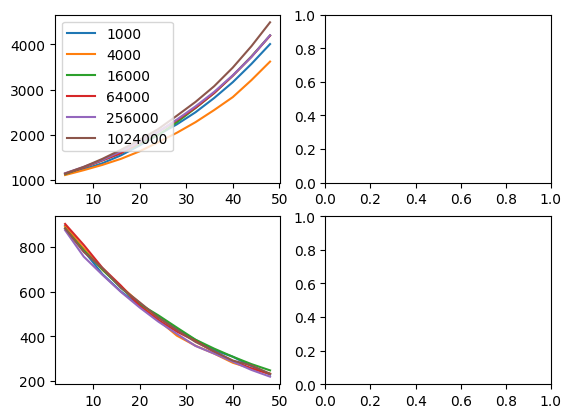

In [68]:
times = [i * 4  + 4 for i in range(12)]
dosages = [min_dose * 4 ** i for i in range(6)]
model = CSANModel(e_receptors, t_receptors)
initial_states = []
for dose in dosages:
    initial_states.append(model.get_free_state(initial_e, dose, initial_t))


fig, ax = plt.subplots(2, 2)
for initial_state in initial_states:
    result = model.run_timepoints(parameters, initial_state, times)
    tumor_count = []
    tcell_count = []
    for time_data in result:
        tumor_count.append(time_data.T())
        tcell_count.append(time_data.E())
    ax[0, 0].plot(times, tumor_count, label=f"{initial_state.D}")
    ax[1, 0].plot(times, tcell_count)
ax[0, 0].legend()
plt.show()


